Develop a reasonably robust model that can

    1.	Predict next-day closing price for APPLE
    2.	Predict next-7-days closing price for APPLE

Note: You are free to do any analysis (visual or tabular) as a pre or post requirement for building the above model and related price prediction.

In [101]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [102]:
all_stock = pd.read_csv("all_stocks_5yr.csv")
cons = pd.read_csv("constituents.csv")
all_data = all_stock.merge(cons, left_on=['Name'], right_on = ['Symbol'], suffixes=('_x', '_company'))
all_data.reset_index(inplace=True, drop=True)
all_data.head()

,date,open,high,low,close,volume,Name_x,Symbol,Name_company,Sector
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,AAL,American Airlines Group,Industrials
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,AAL,American Airlines Group,Industrials
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,AAL,American Airlines Group,Industrials
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,AAL,American Airlines Group,Industrials
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,AAL,American Airlines Group,Industrials


In [103]:
all_comp = list(all_data["Name_company"].unique())
all_df = []
for each_comp in all_comp:
    tmp = all_data.loc[all_data.Name_company == each_comp]
    tmp.loc[:, "yoy_perc"] = tmp.loc[:, "close"].pct_change(periods=365)
    tmp.loc[:, "dod_perc"] = tmp.loc[:, "close"].pct_change(periods=1)
    tmp.loc[:, "avg_dod_perc"] = tmp.loc[:, "dod_perc"].rolling(2).mean()
    tmp.loc[:, "avg_yoy_perc"] = tmp.loc[:, "yoy_perc"].rolling(365).mean()
    tmp.loc[:, "mom_perc"] = tmp.loc[:, "close"].pct_change(periods=30)
    tmp.loc[:, "avg_mom_perc"] = tmp.loc[:, "mom_perc"].rolling(30).mean()
    all_df.append(tmp)
all_data_mod = pd.concat(all_df, axis=0)

splitted = all_data_mod['date'].str.split('-', expand=True)

all_data_mod.loc[:, 'day'] = splitted[2].astype('int')
all_data_mod.loc[:, 'month'] = splitted[1].astype('int')
all_data_mod.loc[:, 'year'] = splitted[0].astype('int')

C:\Users\sunny\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\sunny\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Data Processing

In [104]:
def data_process(all_data_app):
    all_data_app = all_data_app.loc[all_data_mod.Name_company == "Apple", :].sort_values("date", ascending=True)

    splitted = all_data_app['date'].str.split('-', expand=True)

    all_data_app['day'] = splitted[2].astype('int')
    all_data_app['month'] = splitted[1].astype('int')
    all_data_app['year'] = splitted[0].astype('int')

    all_data_app['is_quarter_end'] = np.where(all_data_app['month']%3==0,1,0)
    all_data_app['open-close']  = all_data_app['open'] - all_data_app['close']
    all_data_app['low-high']  = all_data_app['low'] - all_data_app['high']

    forecast_out = 1
    #Create another column (the target ) shifted 'n' units up
    all_data_app['pred1'] = all_data_app[['close']].shift(-1)
    all_data_app['pred7'] = all_data_app[['close']].shift(-7)

    weekly_trend = all_data_app.shift(1).rolling(7).sum()["pred1"]
    all_data_app["weekly_trend1"] = weekly_trend

    weekly_trend = all_data_app.shift(1).rolling(7).sum()["pred7"]
    all_data_app["weekly_trend7"] = weekly_trend

    weekly_mean = all_data_app.rolling(7).mean()["close"]
    quarterly_mean = all_data_app.rolling(90).mean()["close"]
    annual_mean = all_data_app.rolling(365).mean()["close"]

    all_data_app["weekly_mean"] = weekly_mean / all_data_app["close"]
    all_data_app["quarterly_mean"] = quarterly_mean / all_data_app["close"]
    all_data_app["annual_mean"] = annual_mean / all_data_app["close"]

    all_data_app["annual_weekly_mean"] = all_data_app["annual_mean"] / all_data_app["weekly_mean"]
    all_data_app["annual_quarterly_mean"] = all_data_app["annual_mean"] / all_data_app["quarterly_mean"]

    all_data_app["open_close_ratio"] = all_data_app["open"] / all_data_app["close"]
    all_data_app["high_close_ratio"] = all_data_app["high"] / all_data_app["close"]
    all_data_app["low_close_ratio"] = all_data_app["low"] / all_data_app["close"]

    # Also calculate moving averages for features
    all_data_app['ema50'] = all_data_app['close'] / all_data_app['close'].ewm(50).mean()
    all_data_app['ema21'] = all_data_app['close'] / all_data_app['close'].ewm(21).mean()
    all_data_app['ema15'] = all_data_app['close'] / all_data_app['close'].ewm(14).mean()
    all_data_app['ema5'] = all_data_app['close'] / all_data_app['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    all_data_app['normVol'] = all_data_app['volume'] / all_data_app['volume'].ewm(5).mean()
    all_data_app = all_data_app.dropna()

    all_data_app = all_data_app.drop(["Name_x", "Symbol", "Name_company", "Sector", "date"], axis=1)

    sc_X = StandardScaler()
    tmp =  pd.DataFrame(sc_X.fit_transform(all_data_app[features]), columns=features, index=all_data_app.index)

    tmp = tmp.copy(deep=True)
    all_data_app[features] = tmp[features]

    return all_data_app


features = ["yoy_perc", "dod_perc", "open", "high", "low", "close", "volume", "ema5", "ema15", "ema21", "ema50", "normVol", "weekly_mean", "quarterly_mean", "annual_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]
features += ['low-high', 'open-close', "is_quarter_end", "day", "month", "year"]    
all_data_app = data_process(all_data_mod)

In [108]:
# Train test split
train = all_data_app.iloc[:-100]
test = all_data_app.iloc[-100:]
X_train = train.drop(["pred7", "pred1"], axis=1)
X_test = test.drop(["pred7", "pred1"], axis=1)
y_train, y_test = train.pred1, test.pred1

In [109]:
X_train.columns

Index(['open', 'high', 'low', 'close', 'volume', 'yoy_perc', 'dod_perc',
       'avg_dod_perc', 'avg_yoy_perc', 'mom_perc', 'avg_mom_perc', 'day',
       'month', 'year', 'is_quarter_end', 'open-close', 'low-high',
       'weekly_trend1', 'weekly_trend7', 'weekly_mean', 'quarterly_mean',
       'annual_mean', 'annual_weekly_mean', 'annual_quarterly_mean',
       'open_close_ratio', 'high_close_ratio', 'low_close_ratio', 'ema50',
       'ema21', 'ema15', 'ema5', 'normVol'],
      dtype='object')

## Regression models Next Day prediction

In [110]:
lr_1 = LinearRegression()
# Train the model
lr_1.fit(X_train, y_train)

lr_confidence = lr_1.score(X_test, y_test)
y_pred = lr_1.predict(X_test)

print("lr confidence: ", lr_confidence)
print("accuracy: "+ str(lr_1.score(X_test,y_test)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(y_test,y_pred)))
print("Mean squared error: {}".format(mean_squared_error(y_test,y_pred)))
test["prediction"] = y_pred

lr confidence:  0.9584306487115181
accuracy: 95.84306487115181%
Mean absolute error: 1.3580202348022865
Mean squared error: 2.831140477406229


<ipython-input-110-8a2b274b68a6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = y_pred


accuracy: 96.55163394730893%
Mean absolute error: 1.258350293759614
Mean squared error: 2.348559313551834
R Squared: 0.9655163394730893
Adjusted R Squared: 0.9497958471740565


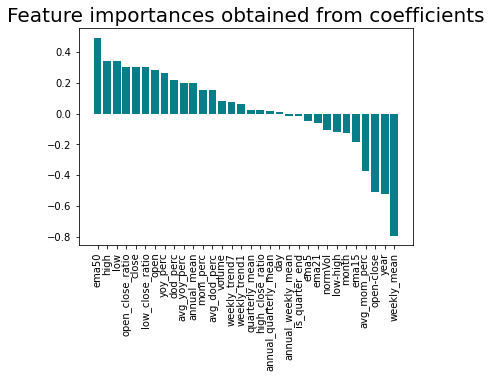

In [111]:
rig_reg_1 = linear_model.Ridge()
rig_reg_1.fit(X_train, y_train)
y_pred = rig_reg_1.predict(X_test)

print("accuracy: "+ str(rig_reg_1.score(X_test, y_test)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(y_test,y_pred)))
print("Mean squared error: {}".format(mean_squared_error(y_test,y_pred)))
R2 = r2_score(y_test,y_pred)
print('R Squared: {}'.format(R2))
n=X_test.shape[0]
p=X_test.shape[1] - 1

adj_rsquared = 1 - (1 - R2) * ((n - 1)/(n-p-1))
print('Adjusted R Squared: {}'.format(adj_rsquared))

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': rig_reg_1.coef_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Regression model 7 day 

In [112]:
train = all_data_app.iloc[:-100]
test = all_data_app.iloc[-100:]
X_train = train.drop(["pred1", "pred7"], axis=1)
X_test = test.drop(["pred1", "pred7"], axis=1)
y_train, y_test = train.pred7, test.pred7

lr confidence:  0.8549227058231164
accuracy: 85.49227058231163%
Mean absolute error: 2.422471927294246
Mean squared error: 9.775186976916336


<ipython-input-113-94d59385edd6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = y_pred


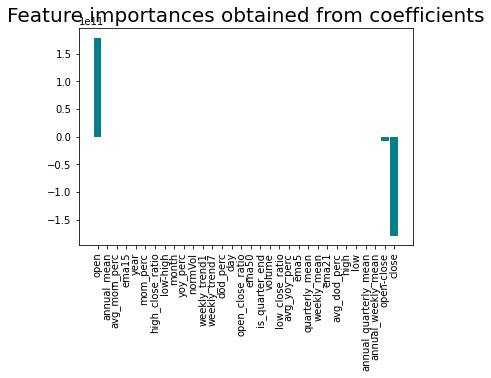

In [113]:
lr_7 = LinearRegression()
# Train the model
lr_7.fit(X_train, y_train)

lr_confidence = lr_7.score(X_test, y_test)
y_pred = lr_7.predict(X_test)

print("lr confidence: ", lr_confidence)
print("accuracy: "+ str(lr_7.score(X_test,y_test)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(y_test,y_pred)))
print("Mean squared error: {}".format(mean_squared_error(y_test,y_pred)))
test["prediction"] = y_pred

import matplotlib.pyplot as plt
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lr_7.coef_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

accuracy: 83.58587499734173%
Mean absolute error: 2.6261119578256613
Mean squared error: 11.05970040824127
R Squared: 0.8358587499734174
Adjusted R Squared: 0.7610296506965929


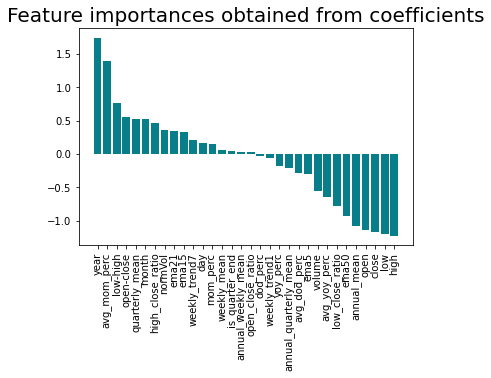

In [114]:
rig_reg_7 = linear_model.Ridge()
rig_reg_7.fit(X_train, y_train)
y_pred = rig_reg_7.predict(X_test)

print("accuracy: "+ str(rig_reg_7.score(X_test, y_test)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(y_test,y_pred)))
print("Mean squared error: {}".format(mean_squared_error(y_test,y_pred)))
R2 = r2_score(y_test,y_pred)
print('R Squared: {}'.format(R2))
n=X_test.shape[0]
p=X_test.shape[1] - 1

adj_rsquared = 1 - (1 - R2) * ((n - 1)/(n-p-1))
print('Adjusted R Squared: {}'.format(adj_rsquared))

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': rig_reg_7.coef_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [115]:
X_test

,open,high,low,close,volume,yoy_perc,dod_perc,avg_dod_perc,avg_yoy_perc,mom_perc,...,annual_weekly_mean,annual_quarterly_mean,open_close_ratio,high_close_ratio,low_close_ratio,ema50,ema21,ema15,ema5,normVol
2411,1.251605,1.224808,1.209928,1.219999,-0.719608,1.077523,-0.151692,-0.006529,0.092520,0.060037,...,0.760714,0.812430,0.584795,-0.025432,-0.116528,0.555116,0.350871,0.232782,-0.146116,-0.399559
2412,1.228495,1.196899,1.203933,1.195741,-0.701591,0.948767,-0.377567,-0.002532,0.093635,0.050828,...,0.761755,0.812523,0.606155,-0.115548,0.360033,0.472353,0.228050,0.090831,-0.318774,-0.302177
2413,1.182647,1.156337,1.135370,1.097589,-0.266552,0.795038,-1.313939,-0.010162,0.094525,0.053600,...,0.765456,0.812746,1.530340,1.374502,1.145423,0.207877,-0.158507,-0.359590,-0.957334,0.528339
2414,1.169228,1.189829,1.186324,1.204698,-0.073265,0.899904,1.306145,0.000892,0.095483,0.080268,...,0.767594,0.812834,-0.569848,-0.521382,-0.336095,0.458974,0.221975,0.104272,-0.117341,0.754276
2415,1.247878,1.260904,1.144362,1.180813,2.539250,0.840239,-0.373627,0.007065,0.096404,0.081557,...,0.770590,0.812899,1.200649,1.888771,-0.815775,0.379493,0.106926,-0.027071,-0.292788,3.914527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,1.795443,1.836951,1.820630,1.784654,-0.001116,1.386954,-0.054597,-0.003978,0.296472,0.045594,...,0.794249,0.845443,0.224657,1.020591,1.048292,0.327352,0.136343,0.080423,-0.088607,0.535611
2507,1.793580,1.757316,1.685002,1.679411,1.197689,1.309430,-1.284962,-0.007851,0.298609,0.028636,...,0.797110,0.845634,1.876115,1.646839,0.316625,0.073932,-0.236220,-0.359281,-0.752239,2.039441
2508,1.691261,1.669867,1.584966,1.563345,0.574324,1.208976,-1.431375,-0.016890,0.300637,-0.009035,...,0.801362,0.846034,2.130135,2.370364,0.707688,-0.198286,-0.627709,-0.812820,-1.377243,0.815528
2509,1.597887,1.560091,1.567357,1.578273,0.419005,1.162185,0.106233,-0.007757,0.302556,-0.001107,...,0.807281,0.846328,0.368651,-0.604718,-0.095794,-0.171076,-0.567030,-0.721715,-1.094642,0.470543


In [ ]:
def predict_price_next_day(inp):
    y_pred = rig_reg_1.predict(inp)
    return round(y_pred[0], 3)

inp = X_test.sort_values(["year", "month", "day"], ascending=False).head(1)                                                                         
price_1 = predict_price_next_day(inp)

def predict_price_next_7day(inp):
    y_pred = rig_reg_7.predict(inp)
    return round(y_pred[0], 3)

# inp = X_test.sort_values(["year", "month", "day"], ascending=False).head(1)                                                                         
price_7 = predict_price_next_day(inp)

print(price_1, price_7)

In [ ]:
X_test

END